# Logistic Model Development with Hyperparameter Optimization

## Import Libraries

In [1]:
# records and calculations
import pandas as pd
import numpy as np

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# core ML
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, confusion_matrix
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler

# Persistence
import joblib
import pickle

# avoid minor warnings
import warnings
warnings.filterwarnings('ignore')

# read file path
from pathlib import Path

## Load Dataset and Saved Artifacts

In [2]:
# dataset path
file = Path(r"../data/CleanedLoanData.csv")

# artifacts path
artifacts_dir = Path(r"../artifacts/feature-selection")

# model path
model_performance_dir = Path(r"../artifacts/models")


In [3]:
# laod dataset
df = pd.read_csv(file)

In [4]:
# feature-target separation
x = df.drop(columns=['LoanStatus'])
y = df['LoanStatus']

In [5]:
# load artifacts
x_train = joblib.load(artifacts_dir / "x_train.pkl")
x_test = joblib.load(artifacts_dir / "x_test.pkl")
y_train = joblib.load(artifacts_dir / "y_train.pkl")
y_test = joblib.load(artifacts_dir / "y_test.pkl")
cv = joblib.load(artifacts_dir / "cv.pkl")

# configure socring metrics
scoring_metrics = 'roc_auc'

## Model Training with Hyperparameter Optimization

In [6]:
# hyperparameter grid
lr_param_grid = {
    'C' : [0.1, 1, 10, 100],
    'penalty': ['l2', 'l1'],
    'solver': ['liblinear'],
    'class_weight': ['balanced']
}

In [7]:
# Initialize model
lr = LogisticRegression(random_state=42, max_iter=1000)

# GridSearch Optimization
lr_grid = GridSearchCV(
    lr,
    lr_param_grid,
    cv=cv,
    scoring=scoring_metrics,
    n_jobs=-1
)

In [8]:
# train model and identify best estimator
lr_grid.fit(x_train, y_train)

best_model = lr_grid.best_estimator_

## Apply Model to Make Prediction and Get Probabilities

In [9]:
# make prediction on training and test set
train_pred = best_model.predict(x_train)
test_pred = best_model.predict(x_test)

In [10]:
# get predicted probabilities
train_proba = best_model.predict_proba(x_train)[:, 1]
test_proba = best_model.predict_proba(x_test)[:, 1]

In [11]:
# Training Metrics
train_auc_roc = roc_auc_score(y_train, train_proba)             # ROC-AUC score
train_auc_pr = average_precision_score(y_train, train_proba)    # average precision
train_acc = accuracy_score(y_train, train_pred)                 # accuracy score
train_precision = precision_score(y_train, train_pred)          # precision score
train_recall = recall_score(y_train, train_pred)                # recall score
train_f1 = f1_score(y_train, train_pred)                        # f1 score
train_accuracy = accuracy_score(y_train, train_pred)            # accuracy score

In [12]:
# Test Metrics
test_auc_roc = roc_auc_score(y_test, test_proba)             # ROC-AUC score
test_auc_pr = average_precision_score(y_test, test_proba)    # average precision
test_acc = accuracy_score(y_test, test_pred)                 # accuracy score
test_precision = precision_score(y_test, test_pred)          # precision score
test_recall = recall_score(y_test, test_pred)                # recall score
test_f1 = f1_score(y_test, test_pred)                        # f1 score
test_accuracy = accuracy_score(y_test, test_pred)            # accuracy score

In [13]:
# performance table
print("=== Optimized Logistic Regression Performance ===")

metrics = [
    ("AUC-ROC", train_auc_roc, test_auc_roc),
    ('AUC-PR', train_auc_pr, test_auc_pr),
    ("Precision", train_precision, test_precision),
    ("Recall", train_recall, test_recall),
    ("F1-Score", train_f1, test_f1),
    ("Accuracy", train_acc, test_acc),
]

# Print header
print(f"{'Metric':<15}{'Training':<12}{'Test':<12}")
print("-" * 39)

# Print each row using a loop
for name, train_val, test_val in metrics:
    print(f"{name:<15}{train_val:<12.4f}{test_val:<12.4f}")

=== Optimized Logistic Regression Performance ===
Metric         Training    Test        
---------------------------------------
AUC-ROC        0.7768      0.8785      
AUC-PR         0.8582      0.9230      
Precision      0.8102      0.8780      
Recall         0.8537      0.8571      
F1-Score       0.8314      0.8675      
Accuracy       0.7623      0.8211      


## ROC-Curve

In [14]:
# roc curve for training and testing set
train_fpr, train_tpr, _ = roc_curve(y_train, train_proba)
test_fpr, test_tpr, _ = roc_curve(y_test, test_proba)

In [15]:
# calculate AUC for training and testing set
train_auc = auc(train_fpr, train_tpr)
test_auc = auc(test_fpr, test_tpr)

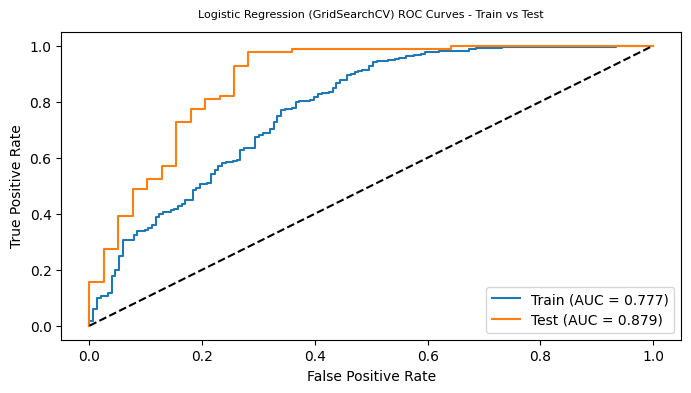

In [16]:
# figure size
plt.figure(figsize=(8, 4))

# ploting the curve
plt.plot(train_fpr, train_tpr, label=f'Train (AUC = {train_auc:.3f})')
plt.plot(test_fpr, test_tpr, label=f'Test (AUC = {test_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')

# set labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression (GridSearchCV) ROC Curves - Train vs Test',  y=1.02, fontsize=8)
plt.legend()
plt.show()

## Cross-Validation Scores

In [17]:
cv_scores = cross_val_score(best_model, x, y, cv=cv, scoring=scoring_metrics)
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

## Persist Final Performance Table

In [18]:
performance_row = {
    'Model': 'Logistic Regression',
    'AUC-ROC': test_auc_roc,
    'AUC-PR': test_auc_pr,
    'Precision': test_precision,
    'Recall': test_recall,
    'F1-Score': test_f1,
    'Accuracy': test_accuracy,
    'CV AUC-ROC Mean': cv_mean,
    'CV AUC-ROC Std': cv_std
}

In [19]:
# file path to save performance
csv_path = model_performance_dir / "model_performance.csv"

# performance dataframe
perf_df = pd.DataFrame([performance_row])
perf_df.to_csv(csv_path, index=False)